<a href="https://www.kaggle.com/code/subhadipde2000/movie-review-sentiment-analysis-with-debertav3?scriptVersionId=195497449" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Necessary imports

In [1]:
import os
os.environ["KERAS_BACKEND"] = "jax"

import keras
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras_nlp.models import DebertaV3Preprocessor, DebertaV3Classifier

2024-09-05 20:47:35.003153: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-05 20:47:35.003257: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-05 20:47:35.126413: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
warnings.filterwarnings("ignore")

# Mixed Precision

In [3]:
keras.mixed_precision.set_global_policy("mixed_float16")

# Reading the dataset

In [4]:
# Reading the dataset
filepath = '/kaggle/input/rotten-tomato-movie-reviews-1-44m-rows/rotten_tomatoes_movie_reviews.csv'
df = pd.read_csv(filepath)
df.head(3)

,id,reviewId,creationDate,criticName,isTopCritic,originalScore,reviewState,publicatioName,reviewText,scoreSentiment,reviewUrl
0,beavers,1145982,2003-05-23,Ivan M. Lincoln,False,3.5/4,fresh,Deseret News (Salt Lake City),Timed to be just long enough for most youngste...,POSITIVE,http://www.deseretnews.com/article/700003233/B...
1,blood_mask,1636744,2007-06-02,The Foywonder,False,1/5,rotten,Dread Central,It doesn't matter if a movie costs 300 million...,NEGATIVE,http://www.dreadcentral.com/index.php?name=Rev...
2,city_hunter_shinjuku_private_eyes,2590987,2019-05-28,Reuben Baron,False,NaN,fresh,CBR,The choreography is so precise and lifelike at...,POSITIVE,https://www.cbr.com/city-hunter-shinjuku-priva...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1444963 entries, 0 to 1444962
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   id              1444963 non-null  object
 1   reviewId        1444963 non-null  int64 
 2   creationDate    1444963 non-null  object
 3   criticName      1444963 non-null  object
 4   isTopCritic     1444963 non-null  bool  
 5   originalScore   1009745 non-null  object
 6   reviewState     1444963 non-null  object
 7   publicatioName  1444963 non-null  object
 8   reviewText      1375738 non-null  object
 9   scoreSentiment  1444963 non-null  object
 10  reviewUrl       1234038 non-null  object
dtypes: bool(1), int64(1), object(9)
memory usage: 111.6+ MB


# Exploratory Data Analysis

In [6]:
# Dropping duplicate rows from the dataframe, if any
num_dup = df.duplicated().sum()
if num_dup > 0:
    df.drop_duplicates(inplace=True)
    print(f"Dropped {num_dup} dupliacte rows from the dataframe.")
    print(f'Now the dataframe has {len(df)} rows.')
else:
    print(f"There are {num_dup} duplicate rows in the dataframe.")

Dropped 12394 dupliacte rows from the dataframe.
Now the dataframe has 1432569 rows.


In [7]:
def review_lengths():
    max_len, min_len, total_len = 0, 99999999999999, 0

    df['reviewText'] = df['reviewText'].astype(str)

    for text in df['reviewText'].tolist():
        if text != None:
            total_len += len(text.split())
            if len(text.split()) > max_len:
                max_len = len(text.split())
            if len(text.split()) < min_len:
                min_len = len(text.split())

    avg_len = round(total_len/len(df))
    print(f"The longest 'reviewText' has {max_len} words, the shortest 'reviewText' has {min_len} words, and the average 'reviewText' length is {avg_len} words.")

In [8]:
review_lengths()

The longest 'reviewText' has 55 words, the shortest 'reviewText' has 1 words, and the average 'reviewText' length is 21 words.


In [9]:
# Checking the elements of the 'reviewText' column which has only 1 word
df[df['reviewText'].apply(lambda x: len(x.split()) == 1)]['reviewText']

32           nan
33           nan
36           nan
37           nan
39           nan
           ...  
1441690      nan
1441691      nan
1441692      nan
1442757      nan
1444578    Yawn.
Name: reviewText, Length: 70420, dtype: object

In [10]:
# Dropping the rows with 'nan' values from the 'reviewText' column
a = len(df)
try:
    df.dropna(subset=['reviewText'], inplace=True)
except:
    pass
else:
    df = df[df['reviewText'] != 'nan']
finally:
    b = len(df)
    x = len(df[df['reviewText'].apply(lambda x: len(x.split()) == 1 and x == 'nan')])
    print(f"Dropped {a-b} rows from the dataframe. \nNow, the dataframe has {x} rows with 'nan' values in the 'reviewText' column.")

Dropped 68694 rows from the dataframe. 
Now, the dataframe has 0 rows with 'nan' values in the 'reviewText' column.


In [11]:
review_lengths()

The longest 'reviewText' has 55 words, the shortest 'reviewText' has 1 words, and the average 'reviewText' length is 22 words.


* As you can see that, after dropping the rows with 'nan' values in the 'reviewText' column, the average length of the reviews has increased from 21 to 22. 

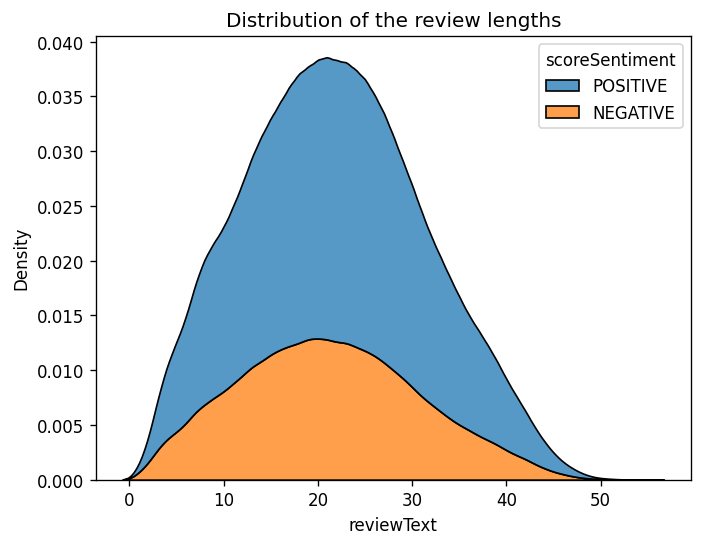

In [12]:
plt.figure(dpi=120)
plt.title('Distribution of the review lengths')
sns.kdeplot(data=df, x=df['reviewText'].str.split().apply(len), hue='scoreSentiment', multiple='stack');

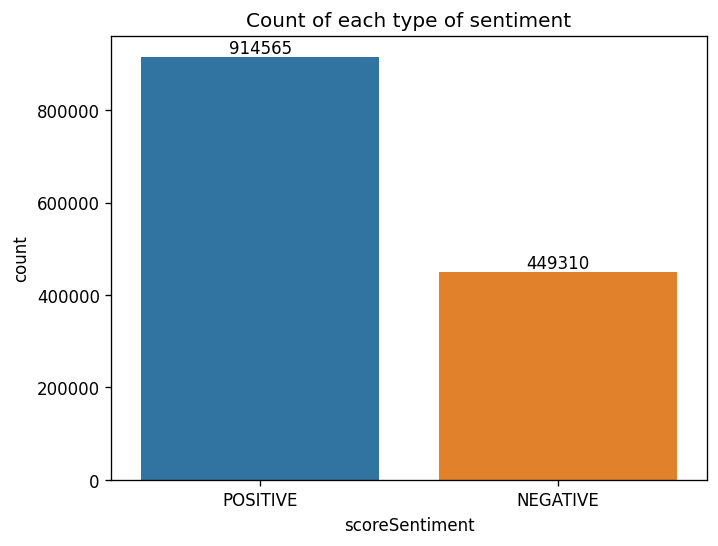

In [13]:
plt.figure(dpi=120)
plt.title("Count of each type of sentiment")
ax = sns.countplot(data=df, x='scoreSentiment')
ax.bar_label(ax.containers[0], fontsize=10);

# Preparing the data

In [14]:
df = df[['reviewText', 'scoreSentiment']].astype(str)
df.head()

,reviewText,scoreSentiment
0,Timed to be just long enough for most youngste...,POSITIVE
1,It doesn't matter if a movie costs 300 million...,NEGATIVE
2,The choreography is so precise and lifelike at...,POSITIVE
3,The film's out-of-touch attempts at humor may ...,NEGATIVE
4,Its clumsy determination is endearing and some...,POSITIVE


In [15]:
df['scoreSentiment'] = df['scoreSentiment'].map({'POSITIVE':1, 'NEGATIVE':0})
df.head()

,reviewText,scoreSentiment
0,Timed to be just long enough for most youngste...,1
1,It doesn't matter if a movie costs 300 million...,0
2,The choreography is so precise and lifelike at...,1
3,The film's out-of-touch attempts at humor may ...,0
4,Its clumsy determination is endearing and some...,1


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1363875 entries, 0 to 1444962
Data columns (total 2 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   reviewText      1363875 non-null  object
 1   scoreSentiment  1363875 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 31.2+ MB


# Train-Validation-Test split

In [17]:
X_train, X_valid, y_train, y_valid = train_test_split(df['reviewText'],
                                                      df['scoreSentiment'],
                                                      test_size=0.03, 
                                                      random_state=42)

X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.5, random_state=42)

# Data Preprocessing

In [18]:
# DeBERTaV3 preprocessor
preprocessor = DebertaV3Preprocessor.from_preset(
    preset="deberta_v3_base_en",
    sequence_length=22 # average length of reviews
)

Attaching 'model.safetensors' from model 'keras/deberta_v3/keras/deberta_v3_base_en/2' to your Kaggle notebook...
Attaching 'model.safetensors.index.json' from model 'keras/deberta_v3/keras/deberta_v3_base_en/2' to your Kaggle notebook...
Attaching 'metadata.json' from model 'keras/deberta_v3/keras/deberta_v3_base_en/2' to your Kaggle notebook...
Attaching 'metadata.json' from model 'keras/deberta_v3/keras/deberta_v3_base_en/2' to your Kaggle notebook...
Attaching 'preprocessor.json' from model 'keras/deberta_v3/keras/deberta_v3_base_en/2' to your Kaggle notebook...
Attaching 'tokenizer.json' from model 'keras/deberta_v3/keras/deberta_v3_base_en/2' to your Kaggle notebook...
Attaching 'tokenizer.json' from model 'keras/deberta_v3/keras/deberta_v3_base_en/2' to your Kaggle notebook...
Attaching 'assets/tokenizer/vocabulary.spm' from model 'keras/deberta_v3/keras/deberta_v3_base_en/2' to your Kaggle notebook...


In [19]:
# Let's have a look at how the DeBERTaV3 pre-processor works
x = random.randint(0, len(df))

text = df.iloc[x, 0]
processed_text = preprocessor(text)

print(f'Original text: \n{text}\n')
print(f'Processed text with DeBERTaV3 preprocessor: \n{processed_text}')

Original text: 
The documentary is very impressive and enchants the eye with its stream of poetic images. It also has almost no narration; it simply wants us to watch in wonder.

Processed text with DeBERTaV3 preprocessor: 
{'token_ids': Array([    1,   279,  6186,   269,   379,  3240,   263, 56787,   268,
         262,  1572,   275,   359,  3961,   265, 16860,  1426,   260,
         325,   327,   303,     2], dtype=int32), 'padding_mask': Array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True], dtype=bool)}


In [20]:
# Function for pre-processing text
def preprocess_fn(text, label=None):
    text = preprocessor(text)
    return (text, label) if label is not None else text

# Building tensorflow datasets

In [21]:
# Function for building tensorflow datasets
def build_tf_dataset(reviews, sentiments=None, BATCH_SIZE=32, shuffle=True):
    AUTO = tf.data.AUTOTUNE
    options = tf.data.Options()
    options.experimental_deterministic = False
    
    reviews = tf.convert_to_tensor(reviews.tolist() if not isinstance(reviews, list) else reviews)
    if sentiments is not None:
        sentiments = [[1, 0] if value == 1 else [0, 1] for value in sentiments]
        sentiments = tf.convert_to_tensor(sentiments)
        
    slices = (reviews,) if sentiments is None else (reviews, sentiments)
    
    dataset = tf.data.Dataset.from_tensor_slices(slices).cache()
    dataset = dataset.map(preprocess_fn, num_parallel_calls=AUTO)
    if shuffle:
        dataset = dataset.shuffle(1024, seed=101)
    dataset = dataset.with_options(options).batch(BATCH_SIZE).prefetch(AUTO)
    
    return dataset

In [22]:
train_dataset = build_tf_dataset(X_train, y_train)
valid_dataset = build_tf_dataset(X_valid, y_valid)
test_dataset = build_tf_dataset(X_test, y_test)

# Modelling

In [23]:
classifier = DebertaV3Classifier.from_preset(
    "deberta_v3_base_en",
    preprocessor=None,
    activation = 'softmax',
    num_classes=2
)
classifier.compile(
    optimizer=keras.optimizers.AdamW(5e-5),
    loss=keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

Attaching 'model.safetensors' from model 'keras/deberta_v3/keras/deberta_v3_base_en/2' to your Kaggle notebook...
Attaching 'model.safetensors.index.json' from model 'keras/deberta_v3/keras/deberta_v3_base_en/2' to your Kaggle notebook...
Attaching 'metadata.json' from model 'keras/deberta_v3/keras/deberta_v3_base_en/2' to your Kaggle notebook...
Attaching 'metadata.json' from model 'keras/deberta_v3/keras/deberta_v3_base_en/2' to your Kaggle notebook...
Attaching 'task.json' from model 'keras/deberta_v3/keras/deberta_v3_base_en/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/deberta_v3/keras/deberta_v3_base_en/2' to your Kaggle notebook...
Attaching 'model.safetensors' from model 'keras/deberta_v3/keras/deberta_v3_base_en/2' to your Kaggle notebook...
Attaching 'model.safetensors.index.json' from model 'keras/deberta_v3/keras/deberta_v3_base_en/2' to your Kaggle notebook...
Attaching 'metadata.json' from model 'keras/deberta_v3/keras/deberta_v3_base_en/2' to yo

In [24]:
classifier.summary()

Model: "deberta_v3_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ deberta_v3_backbone           │ (None, None, 768)         │     183,831,552 │ padding_mask[0][0],        │
│ (DebertaV3Backbone)           │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item (GetItem)            │ (None, 768)               │               0 │ deberta_v3_backbone[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooled_dropout (Dropout)      │ (None, 768)               │               0 │ get_item[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 768)               │         590,592 │ pooled_dropout[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ classifier_dropout (Dropout)  │ (None, 768)               │               0 │ pooled_dense[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │           1,538 │ classifier_dropout[0][0]   │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 184,423,682 (703.52 MB)

 Trainable params: 184,423,682 (703.52 MB)

 Non-trainable params: 0 (0.00 B)

# Model training

In [25]:
history = classifier.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=2
)

Epoch 1/2
41343/41343 ━━━━━━━━━━━━━━━━━━━━ 13099s 316ms/step - accuracy: 0.8491 - loss: 0.3426 - val_accuracy: 0.8759 - val_loss: 0.2969
Epoch 2/2
41343/41343 ━━━━━━━━━━━━━━━━━━━━ 13061s 316ms/step - accuracy: 0.7062 - loss: 0.5753 - val_accuracy: 0.6671 - val_loss: 0.6366


# Model evaluation

In [26]:
test_loss, test_accuracy = classifier.evaluate(test_dataset)
print(f"The model loss on the test dataset is {round(test_loss, 4)}.")
print(f"The model accuracy on the test dataset is {round(test_accuracy*100, 4)}%.")

640/640 ━━━━━━━━━━━━━━━━━━━━ 66s 102ms/step - accuracy: 0.6721 - loss: 0.6328
The model loss on the test dataset is 0.6351.
The model accuracy on the test dataset is 66.9094%.


* Let's now test the model performance on some sample reviews

In [27]:
def predict_sentiments(reviews):
    if isinstance(reviews, list):
        tf_df = build_tf_dataset(reviews, BATCH_SIZE=min(32, len(reviews)))
        preds = classifier.predict(tf_df)
        for i in range(len(reviews)):
            POSITIVE = round(preds[i][0]*100, 3)
            NEGATIVE = round(preds[i][1]*100, 3)
            print(f"REVIEW TEXT:\n{reviews[i]}\nPOSTIVE Sentiment - {POSITIVE}%  |  NEGATIVE Sentiment - {NEGATIVE}%\n\n")
    else:
        print("Put the reviews in a list.")

In [28]:
reviews = [
    "Amazing! A movie that everyone should see.",
    "Incredibly captivating! A cinematic gem that's not to be missed.",
    "Stunningly brilliant! A film that will stay with you forever.",
    "Utterly disappointing. A waste of time with no redeeming qualities. Avoid at all costs.",
    "Dreadfully dull. A complete waste of talent and resources.",
    "Painfully uninspired. A film that lacks any creativity."
]
predict_sentiments(reviews)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
REVIEW TEXT:
Amazing! A movie that everyone should see.
POSTIVE Sentiment - 68.018%  |  NEGATIVE Sentiment - 31.982%


REVIEW TEXT:
Incredibly captivating! A cinematic gem that's not to be missed.
POSTIVE Sentiment - 68.018%  |  NEGATIVE Sentiment - 31.982%


REVIEW TEXT:
Stunningly brilliant! A film that will stay with you forever.
POSTIVE Sentiment - 68.018%  |  NEGATIVE Sentiment - 31.982%


REVIEW TEXT:
Utterly disappointing. A waste of time with no redeeming qualities. Avoid at all costs.
POSTIVE Sentiment - 68.018%  |  NEGATIVE Sentiment - 31.982%


REVIEW TEXT:
Dreadfully dull. A complete waste of talent and resources.
POSTIVE Sentiment - 68.018%  |  NEGATIVE Sentiment - 31.982%


REVIEW TEXT:
Painfully uninspired. A film that lacks any creativity.
POSTIVE Sentiment - 68.018%  |  NEGATIVE Sentiment - 31.982%


